## firstly you must convert models by your system
dockerfile docker/tensorrt/Dockerfile

convertors:
* yolov5 (inference/convertors/yolo2tensorrt/bin/yolov5_tensorrt.sh)
* options (inference/convertors/options2tensorrt/convert_numberplate_options_to_onnx.py)
* ocrs (inference/convertors/ocr2tensorrt/convert_ocr_to_onnx.py)

In [1]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Import all necessary libraries.
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import pycuda.autoinit

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [4]:
from NomeroffNet.YoloV5EngineDetector import Detector

In [5]:
detector = Detector()
detector.load_model(
    engine_file_path="/var/www/nomeroff-net/inference/convertors/yolo2tensorrt/bin/yolov5s-2021-07-28.engine",
    plugin_lib="../inference/convertors/yolo2tensorrt/bin/libmyplugins.so")

In [6]:
from NomeroffNet.BBoxNpPoints import NpPointsCraft, getCvZoneRGB, convertCvZonesRGBtoBGR, reshapePoints

npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights from checkpoint (/var/www/nomeroff-net/NomeroffNet/tools/../../data/./models/NpPointsCraft/craft_mlt/craft_mlt_25k_2020-02-16.pth)
Loading weights of refiner from checkpoint (/var/www/nomeroff-net/NomeroffNet/tools/../../data/./models/NpPointsCraft/craft_refiner/craft_refiner_CTW1500_2020-02-16.pth)


In [7]:
from NomeroffNet.OptionsDetectorOnnx import OptionsDetectorOnnx

optionsDetector = OptionsDetectorOnnx({
    "class_region": [
            "military",
            "eu_ua_2015",
            "eu_ua_2004",
            "eu_ua_1995",
            "eu",
            "xx_transit",
            "ru",
            "kz",
            "eu-ua-fake-dpr",
            "eu-ua-fake-lpr",
            "ge",
            "by",
            "su",
            "kg",
            "am"
        ],
        "count_lines": [
            1,
            2,
            3
        ],
})
optionsDetector.load_model("../data/model_repository/numberplate_options/1/model.onnx")

In [12]:
from NomeroffNet.TextDetectorOnnx import TextDetectorOnnx


# Initialize text detector.
textDetector = TextDetectorOnnx({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "../data/model_repository/ocr-eu_ua_2004_2015/1/model.onnx"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "../data/model_repository/ocr-eu_ua_1995/1/model.onnx"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "../data/model_repository/ocr-eu/1/model.onnx"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "../data/model_repository/ocr-ru/1/model.onnx"
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "../data/model_repository/ocr-kz/1/model.onnx"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "../data/model_repository/ocr-ge/1/model.onnx"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "../data/model_repository/ocr-su/1/model.onnx"
    }
}, default_label="eu")

In [13]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

[[[349.0415576171875, 711.7260589032616], [349.0415576171875, 653.8445013854241], [587.9584423828126, 662.4541161312952], [587.9584423828123, 720.3356736491328]], [[162, 403], [162, 384], [210, 384], [210, 403]]]


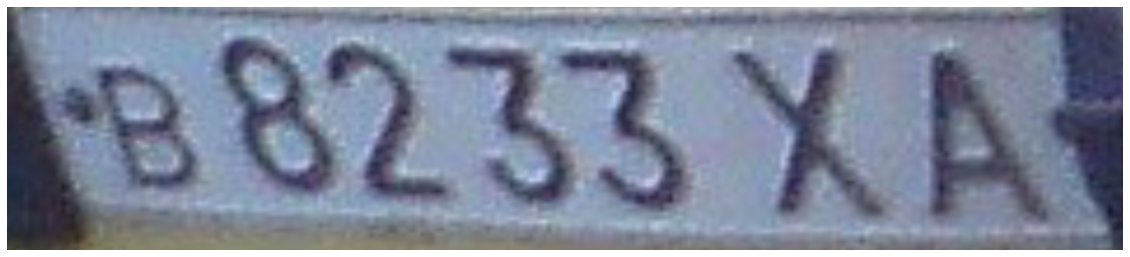

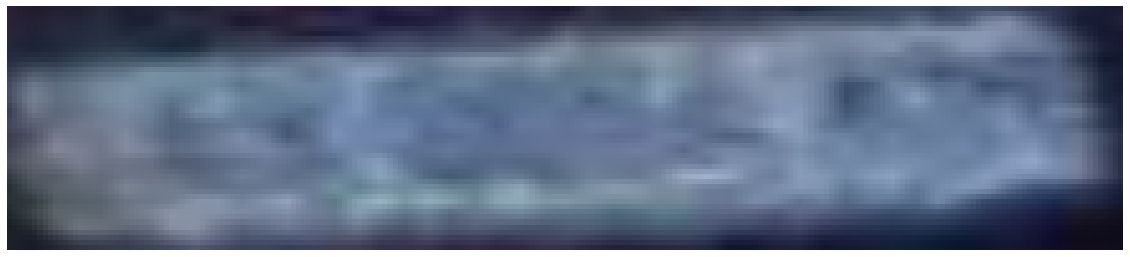

['su', 'am']
[1, 2]


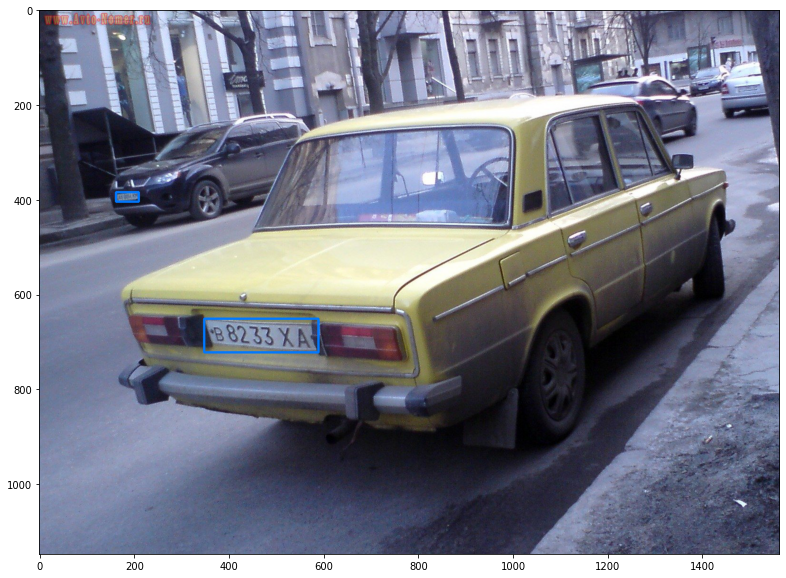

[[[640.0, 496.53333198547364], [640.0, 463.4666665840149], [798.0, 463.4666665840149], [798.0, 496.53333198547364]], [[972, 270], [972, 248], [999, 248], [999, 270]]]


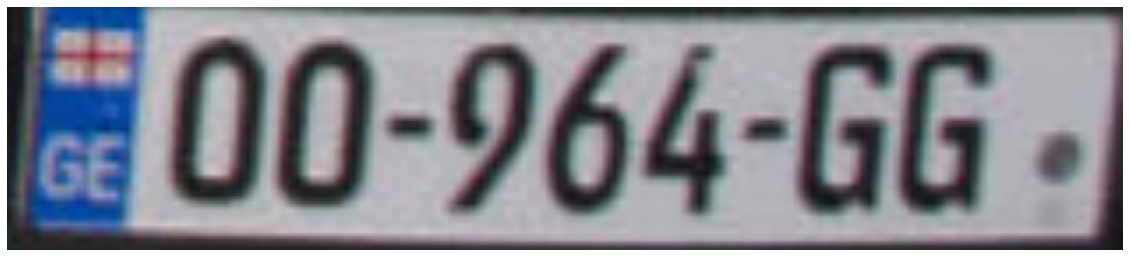

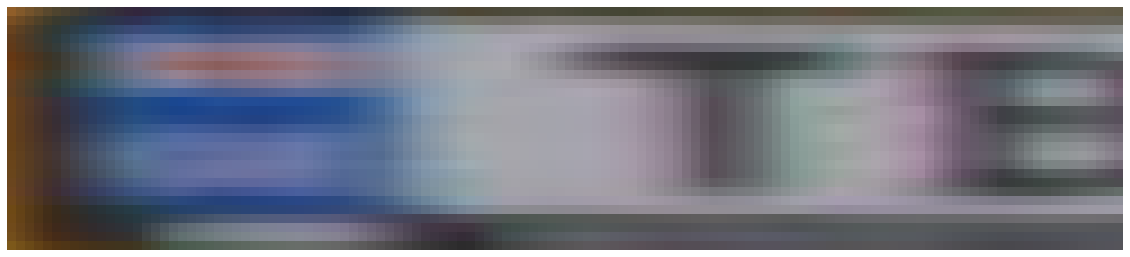

['ge', 'eu_ua_2015']
[1, 3]


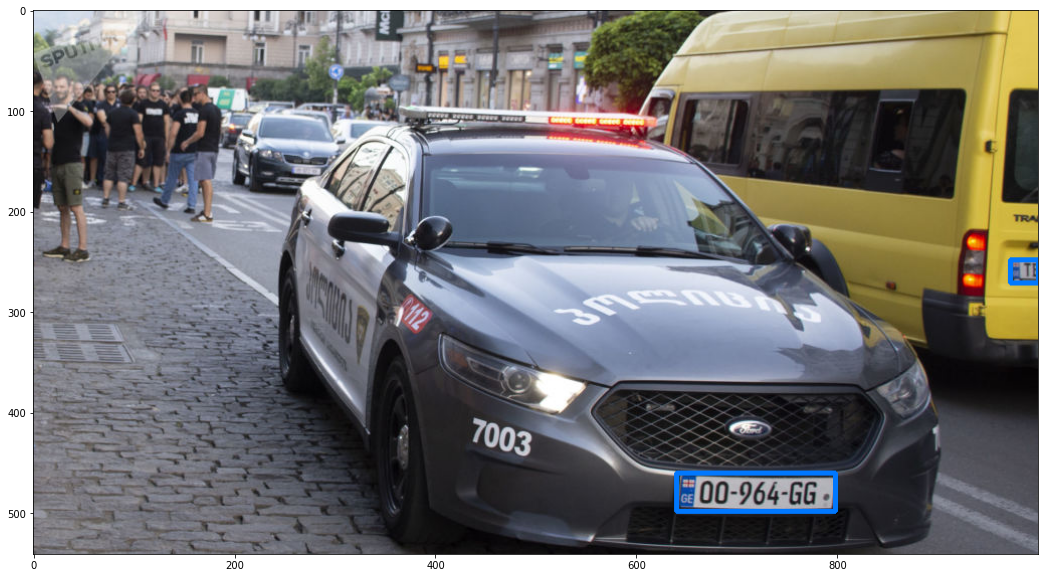

[[[846.2147207383005, 406.1571211590872], [845.7677854662782, 381.1289097098692], [945.8572909545899, 379.34159278869623], [946.3042309609713, 404.3698026956127]], [[432.26666498184204, 402.90666454315186], [432.26666616439815, 379.7599958229065], [525.0, 379.75999174118044], [525.0, 402.90666046142576]]]


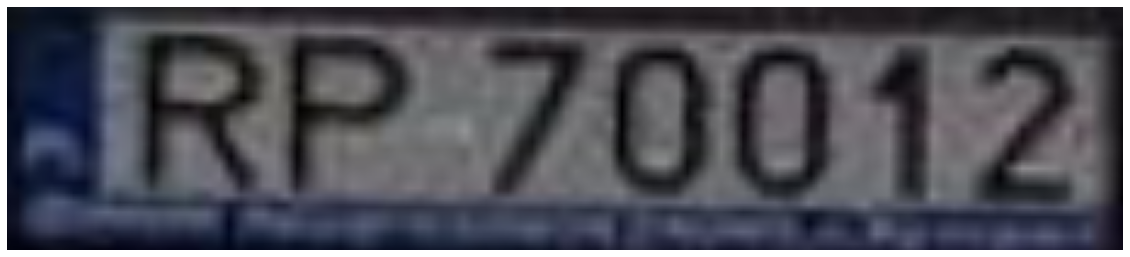

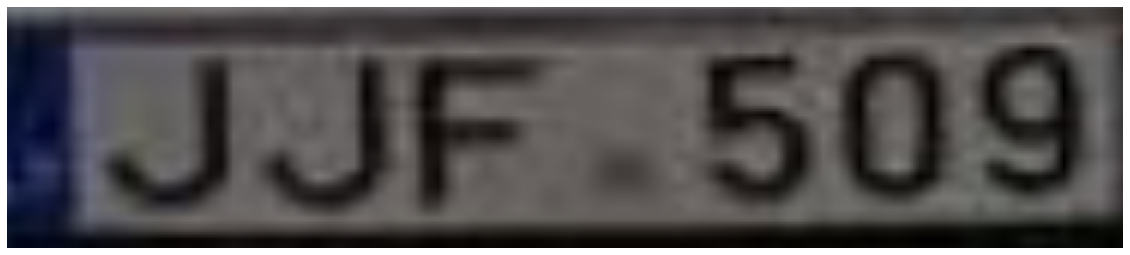

['eu', 'eu']
[1, 1]


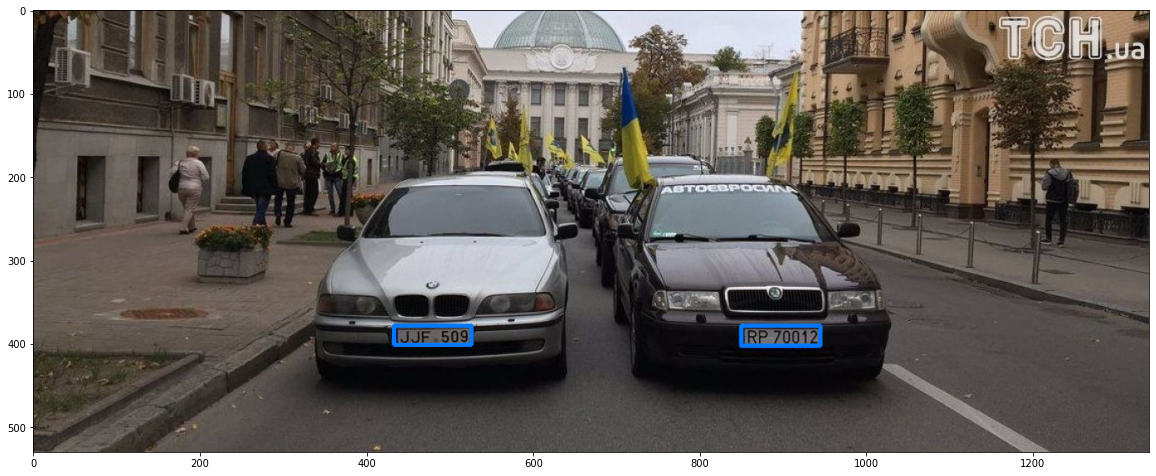

[[[167.54430188555628, 444.6702201731739], [167.54430188555628, 384.5295829015228], [303.2866111964936, 458.57088287909886], [303.2866006046345, 518.7115189189307]]]


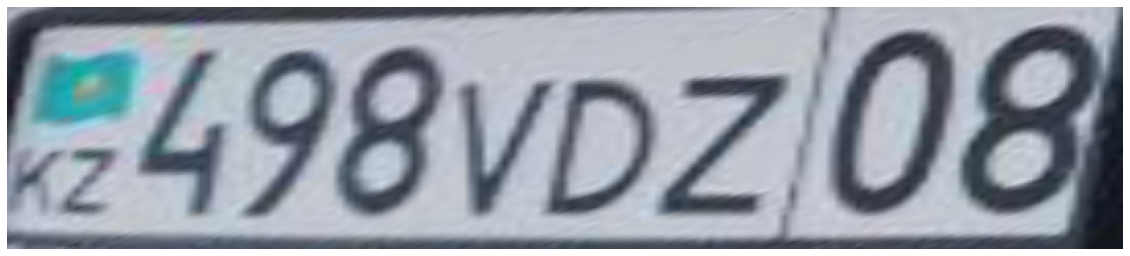

['kz']
[1]


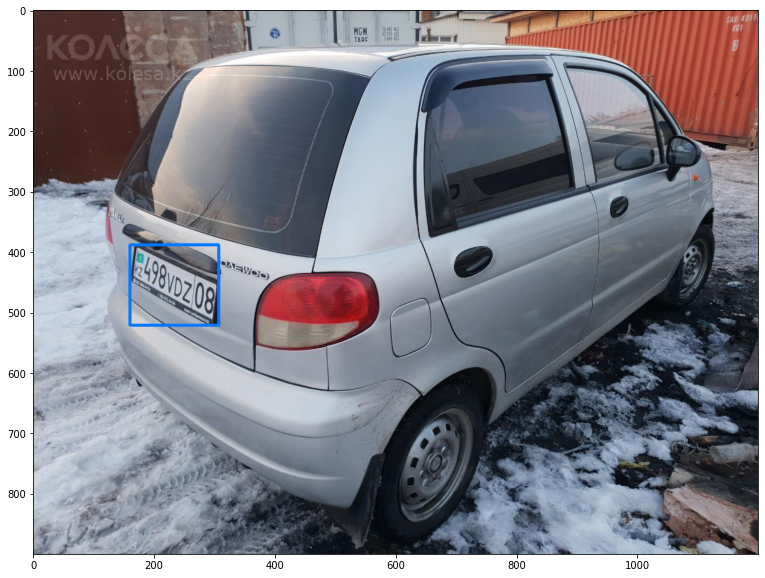

[[[874.2355382077455, 570.2666455188828], [874.2355382077454, 512.6624151014871], [1080.7644639159657, 465.63105383665106], [1080.7644617922547, 523.2352789684467]]]


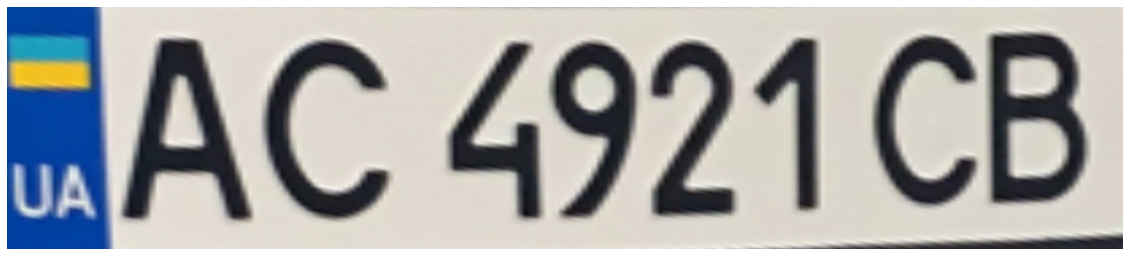

['eu_ua_2015']
[1]


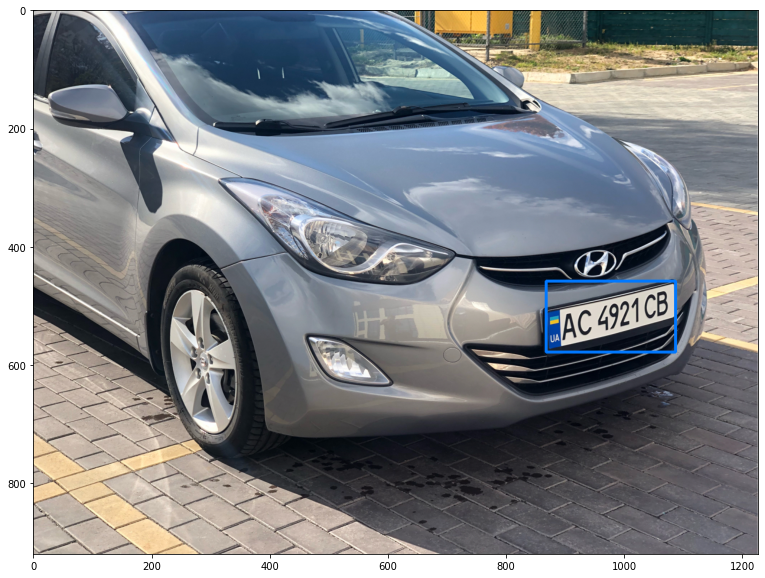

[[[1698.08948120672, 1050.6772924805266], [1698.08948120672, 997.3439665945036], [1780.2117674212905, 930.6196129036719], [1780.2117707867174, 983.9529369162744]]]


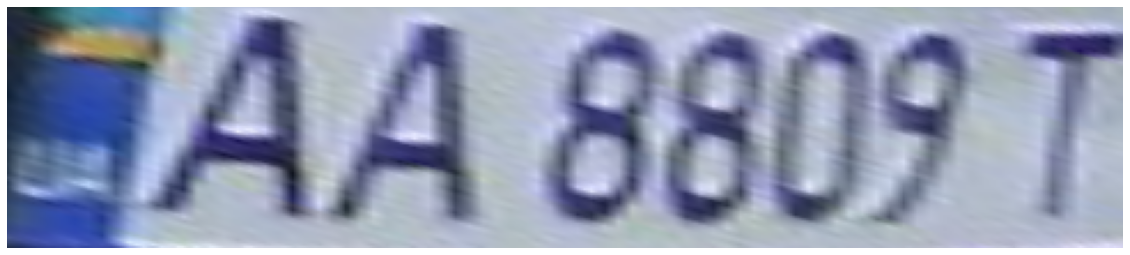

['eu_ua_2015']
[1]


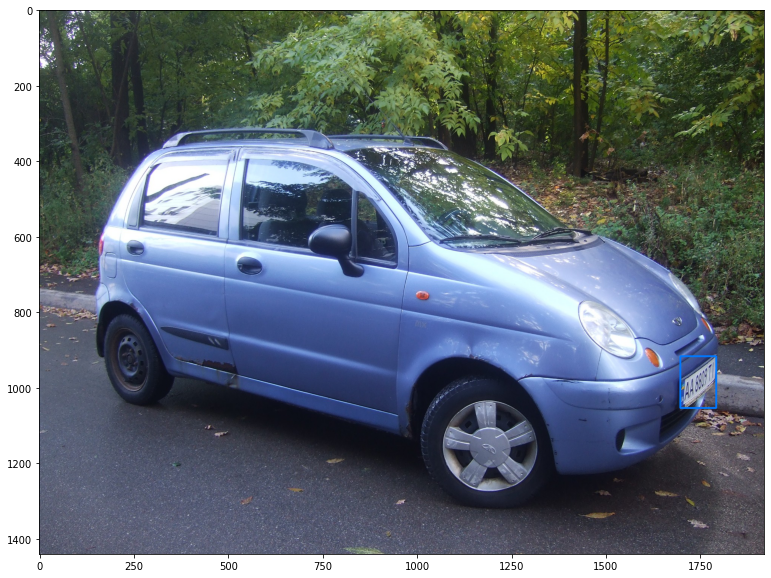

[[[1728.2800078165687, 1803.623460135745], [1712.3468185964775, 1638.7408291110278], [2581.066862762454, 1554.7933365525835], [2597.0, 1719.6759680939485]]]


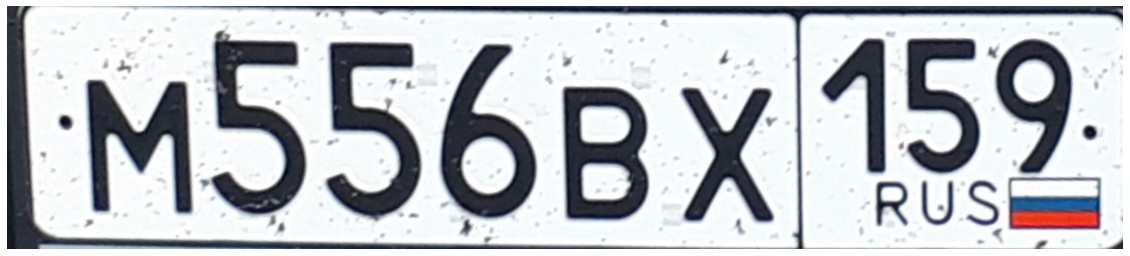

['ru']
[1]


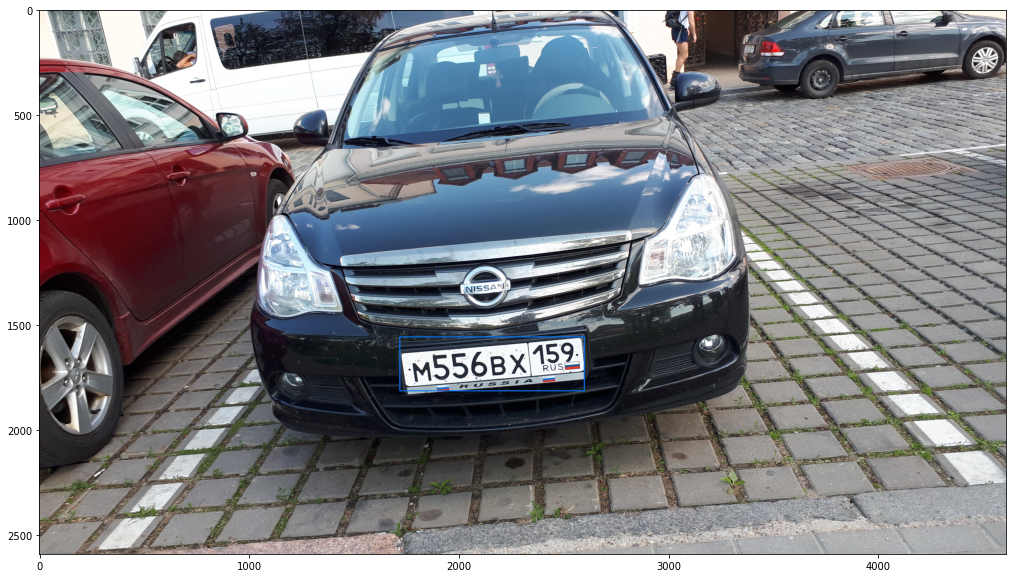

In [14]:
rootDir = 'images/*'

imgs = [mpimg.imread(img_path) for img_path in glob.glob(rootDir)]

for img in imgs:
    targetBoxes = detector.detect_bbox([img])
    targetBoxes = targetBoxes

    all_points = npPointsCraft.detect(img, targetBoxes)
    all_points = [ps for ps in all_points if len(ps)]
    print(all_points)

     # cut zones
    toShowZones = [getCvZoneRGB(img, reshapePoints(rect, 1)) for rect in all_points]
    zones = convertCvZonesRGBtoBGR(toShowZones)
    for zone, points in zip(toShowZones, all_points):
        plt.axis("off")
        plt.imshow(zone)
        plt.show()

    # find standart
    regionIds, countLines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    print(regionNames)
    print(countLines)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, countLines)

    # draw rect and 4 points
    for targetBox, points in zip(targetBoxes, all_points):
        cv2.rectangle(img, 
                      (int(targetBox[0]), int(targetBox[1])), 
                      (int(targetBox[2]), int(targetBox[3])), 
                      (0,120,255), 
                      3)
    plt.imshow(img)
    plt.show()